In [5]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup
import time

import scrab_data

In [6]:
class Environment:
    def __init__(self):
        self.stocks_objects = list()

env = Environment()

In [ ]:
class Tickers:
    df_tickers = pd.DataFrame()
    ticker_file_name = "tickers.csv"
    url = "https://app.scrab.com/screener/"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:143.0) Gecko/20100101 Firefox/143.0",
        "Referer": "https://app.scrab.com/screener/",
        "Origin": "https://app.scrab.com",
        "Hx-Request": "true",
        "X-CSRFToken": scrab_data.CSRF_TOKEN,
    }
    cookies = {
        "sessionid": scrab_data.SESSION_ID,
        "csrftoken": scrab_data.CSRF_TOKEN
    }

    def __init__(self):
        try:
            self.df_tickers = pd.read_csv(self.ticker_file_name)
        except FileNotFoundError:
            self.fetch_tickers()
            self.df_tickers.to_csv(self.ticker_file_name, index=False)

    def fetch_tickers(self, debug=False):
        self.df_tickers = pd.DataFrame()
        i = 0

        current_rows = self.df_tickers.shape[0]
        fetch_more = True

        while fetch_more:
            fetch_more = False
            market_cap_less = None
            if current_rows > 0:
                self.df_tickers.sort_values(by="Market Cap (USD)", inplace=True, ascending=False, key=lambda x: x.astype(float))
                market_cap_less = str(float(self.df_tickers["Market Cap (USD)"].iloc[-1]) - 1)
                if debug:
                    print(f"Fetching more tickers with market cap less than {market_cap_less}")

            fetched_tickers_data = self.fetch_data(market_cap_less=market_cap_less)
            self.parse_data(fetched_tickers_data)

            if debug:
                self.df_tickers.to_csv(f"tickers_page_{i}.csv", index=False)

            if self.df_tickers.shape[0] > current_rows:
                fetch_more = True
                current_rows = self.df_tickers.shape[0]
                i += 1
                time.sleep(1)
            
            if current_rows % 10 != 0:
                self.df_tickers.sort_values(by="Market Cap (USD)", inplace=True, ascending=False, key=lambda x: x.astype(float))
                print(f"Fetched {current_rows} tickers, exit loop")
                fetch_more = False

    def parse_data(self, html_data):
        soup = BeautifulSoup(html_data, 'html.parser')
        table = soup.find("table", {"id": "screener-results-table"})
        headers = [th.get_text(strip=True) for th in table.find("thead").find_all("th")][1:]  # skip checkbox

        rows = []
        for tr in table.find("tbody").find_all("tr"):
            tds = tr.find_all("td")[1:]  # skip row number
            row = []
            for td in tds:
                a = td.find("a")
                if a:
                    row.append(a.get_text(strip=True))
                else:
                    span = td.find("span")
                    if span:
                        row.append(span.get_text(strip=True))
                    else:
                        row.append(td.get_text(strip=True))
            rows.append(row)

        new_tickers = pd.DataFrame(rows, columns=headers)
        new_tickers["Revenue Average Estimated Annual Growth in Next 2 Years"] = new_tickers["Revenue Average Estimated Annual Growth in Next 2 Years"].str.replace(r'[^0-9.]', '', regex=True)
        new_tickers["EPS Average Estimated Annual Growth in Next 2 Years"] = new_tickers["EPS Average Estimated Annual Growth in Next 2 Years"].str.replace(r'[^0-9.]', '', regex=True)
        new_tickers["EPS Long Term (5 Years) Growth Estimates"] = new_tickers["EPS Long Term (5 Years) Growth Estimates"].str.replace(r'[^0-9.]', '', regex=True)
        new_tickers["CFO per Share Average Estimated Annual Growth in Next 2 Years"] = new_tickers["CFO per Share Average Estimated Annual Growth in Next 2 Years"].str.replace(r'[^0-9.]', '', regex=True)

        self.df_tickers = pd.concat([self.df_tickers, new_tickers], ignore_index=True)

    def fetch_data(self, market_cap_less=None, debug=False):
        form_data = {
            "csrfmiddlewaretoken": scrab_data.CSRF_TOKEN,
            "countries": '[{"value":"USA","code":"us","extra":"AMEX, NASDAQ, NYSE","searchBy":"NasdaqGS,Global,Capital,New,York,North,America,United,States,AMEX,NASDAQ,NYSE"}]',
            "market_cap_greater": "10000000000",
            "sales_est_2fy_avg_greater": "5",
            "eps_est_2fy_avg_greater": "7",
            "price_greater": "15",
            "eps_est_2y_num_est_greater": "5",
            "eps_est_long_term_growth_num_est_greater": "5",
            "eps_est_long_term_growth_greater": "10",
            "cfo_per_share_est_2fy_avg_greater": "7",
        }
        if market_cap_less is not None:
            form_data["market_cap_less"] = market_cap_less

        response = requests.post(
            "https://app.scrab.com/screener/",
            data=form_data,
            headers=self.headers,
            cookies=self.cookies
        )

        if debug:
            print(response.status_code)
            with open("fetch_tickers_response.html", "w", encoding="utf-8") as f:
                f.write(response.text)
        return response.text

    def get_tickers(self):
        return self.df_tickers["Ticker"].to_list()

# Load or fetch tickers
tickers = Tickers()

FileNotFoundError: [Errno 2] No such file or directory: 'tickers.csv'

In [ ]:
screener = tickers.get_tickers()
# [
    # "SRPT",
#     # "AMD",
#     # "AMZN", 
#     # "GOOG", 
#     "META", 
#     # "AVGO", 
#     # "ORCL", 
#     "LLY", 
#     "NFLX",
#     # "ABBV", 
#     "ASML", 
#     "SAP", 
#     "CRM", 
#     "INTU", 
#     "NOW", 
#     "ISRG", 
#     "ADBE", 
#     # "SPOT", 
#     # "CRWD", 
#     # "SE", 
#     # "CDNS", 
#     # "CI", 
#     # "RMD", 
#     # "EFX", 
#     # "PTC", 
#     # "PINS", 
#     # "FSLR", 
#     "DKNG", 
#     # "BE", 
#     # "TRU", 
#     # "OKTA", 
#     # "DT"
#     "DECK",
#     "OKTA",
#     "V",
#     "MA",
#     "WDAY",
#     "MRK",
#     "TOL",
#     "UNH",
# ]

In [4]:
class Stock:
    def __init__(self, ticker):
        self.sigma_coeff = 1
        self.expensiveness_coeff = 1.2

        self.ticker = ticker
        self.df = pd.DataFrame()
        self.trela_indicator = None

        # Fetched metrics
        self.fetch_metric("price")
        self.fetch_metric("price_target")
        self.fetch_metric("price_target_upside")

        self.fetch_metric("forward_pe_ratio")
        self.fetch_metric("forward_pe_ratio:median:3")

        self.fetch_metric("forward_ps_ratio")    
        self.fetch_metric("forward_ps_ratio:median:3")

        # Placeholder metrics
        # Initialize buy / sell to false
        for col in ['buy', 'sell']:
            if col not in self.df.columns:
                self.df[col] = False
                
        self.postprocess_metrics()
        env.stocks_objects.append(self)

    def fetch_metric(self, metric):
        response_metric = self._request_data(self.ticker, metric)
        metric_df = pd.DataFrame(response_metric[0]['datapoints'], columns=['timestamp', metric])
        metric_df.insert(0, 'date', pd.to_datetime(metric_df['timestamp'], unit='s'))
        metric_df = metric_df.drop(columns='timestamp')
        if self.df.empty:
            self.df = metric_df
        else:
            self.df = pd.merge(self.df, metric_df, on='date', how='left')

    def postprocess_metrics(self):
        # Forward fill price targets
        self.df['price_target'] = self.df['price_target'].ffill()
        
        # TODO: Improveme it, maybe move somewhere else as the definition for "good deal" should be customizable
        # Get buy / sell bands based on 3 sigma (2 sigma for buy, 1 sigma for sell)
        self.calculate_sigma_to_dataframe(metric="price_target_upside")
        self.get_trend("price_target", add_to_dataframe=True)
        self.calculate_trela_indicator()

    def _request_data(self, ticker, metric):
        url = "https://app.scrab.com/data/metric/"
        payload = {
        "tickers":[ticker],
        "metrics":[metric],
        "economic":[],
        "index":1
        }
        cookies = {
            "sessionid": scrab_data.SESSION_ID,
            "csrftoken": scrab_data.CSRF_TOKEN
        }
        headers = {
            "Content-Type": "application/json",
            "User-Agent": "Mozilla/5.0",
            "X-CSRFToken": scrab_data.CSRF_TOKEN,
            "Referer": "https://app.scrab.com/charts/master/",
            "Origin": "https://app.scrab.com"
        }
        response = requests.post(url, json=payload, headers=headers, cookies=cookies)
        data = response.json()
        return data
  
    def plot(self, title, metrics, log_scale=False, start_date="1900-01-01"):
        df_plot = self.df[self.df['date'] >= pd.to_datetime(start_date)]
        fig, ax = plt.subplots(figsize=(12,6))
        for metric in metrics:
            ax.plot(df_plot['date'], df_plot[metric], label=metric)
            ax.set_title(title)
            ax.set_xlabel('Date')
            ax.set_ylabel(str(metrics))
            ax.legend()
            ax.grid(True)
            if log_scale:
                ax.set_yscale('log')  # make y-axis logarithmic
        return ax

    def calculate_sigma_to_dataframe(self, metric, window_upper=504, window_lower=126):
        # rolling mean & std
        self.df[metric + '_mean_upper'] = self.df[metric].rolling(window_upper, min_periods=1).mean()
        self.df[metric + '_std_upper'] = self.df[metric].rolling(window_upper, min_periods=1).std()
        self.df[metric + '_mean_lower'] = self.df[metric].rolling(window_lower, min_periods=1).mean()
        self.df[metric + '_std_lower'] = self.df[metric].rolling(window_lower, min_periods=1).std()

        # bands
        self.df[metric + '_upper_band'] = self.df[metric + '_mean_upper'] + self.sigma_coeff * self.df[metric + '_std_upper']
        self.df[metric + '_lower_band'] = self.df[metric + '_mean_lower'] - self.sigma_coeff * self.df[metric + '_std_lower']
    
    def get_sigma(self, metric, window=252):
        mean = self.df[metric].tail(window).mean()
        std = self.df[metric].tail(window).std()
        upper_band = mean + self.sigma_coeff * std
        lower_band = mean - self.sigma_coeff * std
        return mean, std, upper_band, lower_band

    def get_trend(self, metric, window=252, add_to_dataframe=False, debug=False):
        y = self.df[metric].tail(window).to_numpy()
        X = np.arange(len(y)).reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        
        # create trend line points so it can be plotted
        # and add it to the dataframe
        if add_to_dataframe:
            trend_data_points = model.predict(X)
            self.df.loc[self.df.index[-window:], metric + '_trend'] = trend_data_points
        if debug:
            print(model.coef_)
            print(model.intercept_)
        return model.coef_[0] > 0
    
    # to calculate Trela Indicator we need to calculate in order:
    # 1. Is the stock expensive? - forward_pe_ratio > 1.2 * forward_pe_ratio:median:3
    #                              forward_ps_ratio > 1.2 * forward_ps_ratio:median:3
    # FOR NOW WE WILL CHECK IF forward_pe_ratio > than forward_pe_ratio + sigma_coeff
    # 2. Is price target upside very low? - price_target_upside < lower_band (1.75 sigma)
    # 3. Is price target trend positive? - get_trend("price_target", window=252) > 0
    def calculate_trela_indicator(self, debug=False):
        latest_pe_ratio = self.df['forward_pe_ratio'].iloc[-1]
        latest_pe_ratio_median = self.df['forward_pe_ratio:median:3'].iloc[-1]
        latest_ps_ratio = self.df['forward_ps_ratio'].iloc[-1]
        latest_ps_ratio_median = self.df['forward_ps_ratio:median:3'].iloc[-1]

        is_very_expensive = False
        if latest_pe_ratio > latest_pe_ratio_median * self.expensiveness_coeff\
        or latest_ps_ratio > latest_ps_ratio_median * self.expensiveness_coeff:
            is_very_expensive = True
        
        if debug:
            print(f"{self.ticker} - latest_pe_ratio: {latest_pe_ratio}, "
                  f"latest_pe_ratio_median: {latest_pe_ratio_median}, "
                  f"latest_ps_ratio: {latest_ps_ratio}, "
                  f"latest_ps_ratio_median: {latest_ps_ratio_median}, "
                  f"expensiveness_coeff: {self.expensiveness_coeff}, "
                  f"is_very_expensive: {is_very_expensive}"
            )
        
        latest_upside_lower_band = self.get_sigma("price_target_upside", window=126)[-1]
        latest_upside = self.df['price_target_upside'].iloc[-1]
        is_upside_very_low = latest_upside < latest_upside_lower_band

        is_price_target_trend_positive = self.get_trend("price_target", window=252)

        if debug:
            print(f"{self.ticker} - latest_upside: {latest_upside}, "
                  f"latest_upside_lower_band: {latest_upside_lower_band}, "
                  f"is_upside_very_low: {is_upside_very_low}, "
                  f"is_price_target_trend_positive: {is_price_target_trend_positive}"
            )

        if is_very_expensive:
            if is_upside_very_low:
                self.trela_indicator = "SELL"
            else:
                self.trela_indicator = "HOLD"
        else:
            if is_upside_very_low:
                if is_price_target_trend_positive:
                    self.trela_indicator = "HOLD"
                else:
                    self.trela_indicator = "SELL"
            else:
                self.trela_indicator = "HOLD"

        if debug:
            print(f"{self.ticker} - Trela Indicator: {self.trela_indicator}")

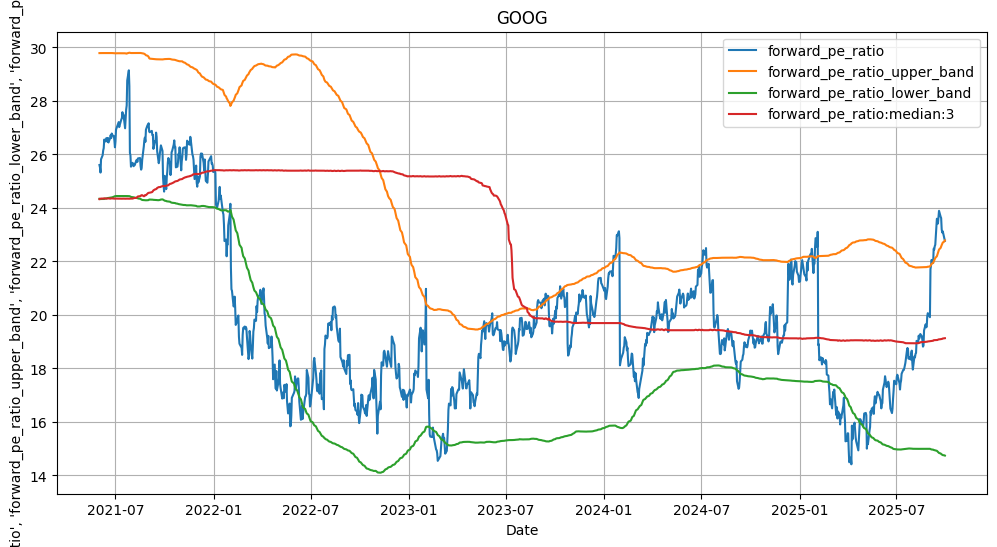

In [38]:
goog = Stock("GOOG")
ax = goog.plot(
goog.ticker,
# ["price_target", "price_target_trend"],
["forward_pe_ratio", "forward_pe_ratio_upper_band", "forward_pe_ratio_lower_band", "forward_pe_ratio:median:3"],
start_date="2021-06-01"
)

In [5]:
# msft = Stock("MSFT")
# ax = msft.plot("Price & Target", ["price", "price_target"], log_scale=True, start_date="2015-01-01")
# ax = msft.plot(
#     "Price target upside with sigma bands",
#     ["price_target_upside", "upper_band", "lower_band"],
#     start_date="2015-01-01"
# )

GOOG: SELL -- Upside -2.31, 1.0% worse than 2 sigma


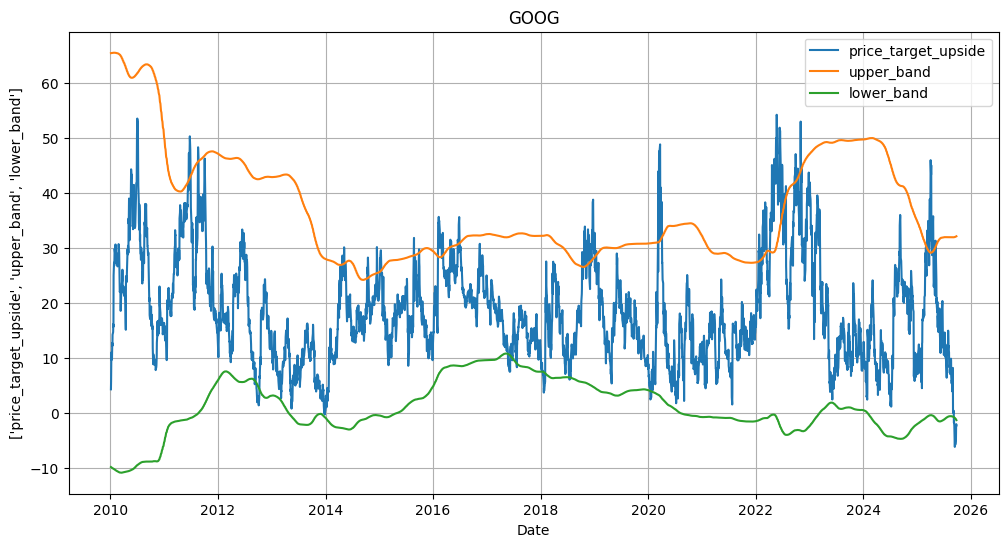

In [6]:
for ticker in screener:
    stock = Stock(ticker)
    latest_upside = stock.df['price_target_upside'].iloc[-1]
    latest_upper_band = stock.df['price_target_upside_upper_band'].iloc[-1]
    latest_lower_band = stock.df['price_target_upside_lower_band'].iloc[-1]
    if latest_upside >= latest_upper_band:
        print(f"{stock.ticker}: BUY -- Upside {latest_upside:.2f}, {latest_upside-latest_upper_band:.1f}% better than 2 sigma. Trela indicator: {stock.trela_indicator}")
        ax = stock.plot(
        stock.ticker,
        ["price_target_upside", "price_target_upside_upper_band", "price_target_upside_lower_band"],
        start_date="2020-01-01"
        )
    if latest_upside <= latest_lower_band:
        print(f"{stock.ticker}: SELL -- Upside {latest_upside:.2f}, {latest_lower_band-latest_upside:.1f}% worse than 2 sigma. Trela indicator: {stock.trela_indicator}")
        ax = stock.plot(
        stock.ticker,
        ["price_target_upside", "price_target_upside_upper_band", "price_target_upside_lower_band"],
        start_date="2020-01-01"
        )

In [7]:
class Screener:
    def __init__(self):
        self.tickers = list()

In [8]:
class Strategy:
    def __init__(self, buy_rule, sell_rule):
        self.buy_rule = buy_rule    # function: row -> bool
        self.sell_rule = sell_rule  # function: row -> bool

    def should_buy(self, row):
        return self.buy_rule(row)

    def should_sell(self, row):
        return self.sell_rule(row)

In [9]:
class Scorer:
    def __init__(self, stocks, criteria):
        self.stocks = stocks
        # What criteria?
        self.criteria = criteria

In [10]:
class AssetAllocator:
    def __init__(self, stocks, allocation):
        self.stocks = stocks
        self.stock_to_allocation = dict()
        allowed_allocation = set('equal_weights')
        if allocation not in allowed_allocation:
            raise ValueError(f'allocation must be one of {allowed_allocation}, got {allocation}')
        self.allocation = allocation

        match self.allocation:
            case 'equal_weights':
                n = len(self.stocks)
                self.stock_to_allocation = {stock: 1 / n for stock in stocks}


In [ ]:
class PortfolioBacktester:
    def __init__(self, stocks, strategy, initial_cash=1000, start_date = "2010-01-01"):
      self.stocks = stocks
      self.strategy = strategy
      self.cash = initial_cash
      self.simulation_date = pd.to_datetime(start_date)
      self.positions = {}  # ticker -> shares
      self.history = []
        
    def run(self):
        # Inital pass for portioning. We don't know 
        for stock in self.stocks:
            last_trading_day = stock.df['date'].max()
            today = pd.Timestamp.today().normalize()
            stop_date = min(last_trading_day, today)
            
            print(f'Simulation time: {(stop_date - self.simulation_date).days} days')

            while self.simulation_date <= stop_date:
                # Sometime start date is non-trading day, find first date that matches the start date
                df_slice = stock.df[stock.df['date'] <= self.simulation_date]
                latest_date = df_slice.iloc[-1]['date']
                latest_row = df_slice.iloc[-1]
                # Determine which stocks to buy
                buy = strategy.should_buy(latest_row)
                sell = strategy.should_sell(latest_row)
                assert not (buy and sell)
                if buy:
                    stock.df.loc[stock.df['date'] == latest_date, 'buy'] = buy
                elif sell:
                    stock.df.loc[stock.df['date'] == latest_date, 'sell'] = sell

                self.simulation_date += pd.Timedelta(days=1)

                # Decide stock allocation
                

buy_rule = lambda row: row['price_target_upside'] > row['upper_band']
sell_rule = lambda row: row['price_target_upside'] < row['lower_band']
allocation = 'equal_weights'
strategy = Strategy(buy_rule, sell_rule)
test_stocks = [Stock('MSFT')]
backtester = PortfolioBacktester(test_stocks, strategy, initial_cash=1000)
backtester.run()

Simulation time: 5747 days
